# Linear Regression

Performing linear regression modeling on red and white wine data.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
### Ignore warnings for final notebook output.
import warnings, os
warnings.simplefilter('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
red_wine = pd.read_csv('./data/winequality-red.csv', sep = ';')
white_wine = pd.read_csv('./data/winequality-white.csv', sep = ';')

In [4]:
from sklearn.model_selection import train_test_split

red_train, red_test = train_test_split(red_wine, test_size=0.2, random_state=42, stratify=red_wine['quality'])

In [5]:
def extract_X_and_Y(df, target):
    X = df.drop(target, axis=1)
    Y = df[target]
    return X, Y

In [6]:
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

# Function to plot the confusion matrix between true and predicted values
# and also prints and returns the precision of each label
def confusion_matrix_and_class_precision(Y_true, Y_pred, labels, title, color):
    class_precision = precision_score(Y_true, Y_pred, average=None, zero_division=0.0)
    cm = confusion_matrix(Y_true, Y_pred)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap=color, xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()
    
    print(class_precision)
    return class_precision

## Red Wine Dataset

In [7]:
red_X_train, red_Y_train = extract_X_and_Y(red_train, 'quality')
red_X_test, red_Y_test = extract_X_and_Y(red_test, 'quality')

In [8]:
red_X_train.shape, red_X_test.shape

((1279, 11), (320, 11))

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

red_lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

red_lr_param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()]
}

red_lr_grid = GridSearchCV(red_lr_pipeline, red_lr_param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
red_lr_grid.fit(red_X_train, red_Y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid={'scaler': [StandardScaler(), MinMaxScaler(),
                                    RobustScaler()]},
             scoring='neg_mean_squared_error')

In [10]:
red_lr_grid.best_params_

{'scaler': StandardScaler()}

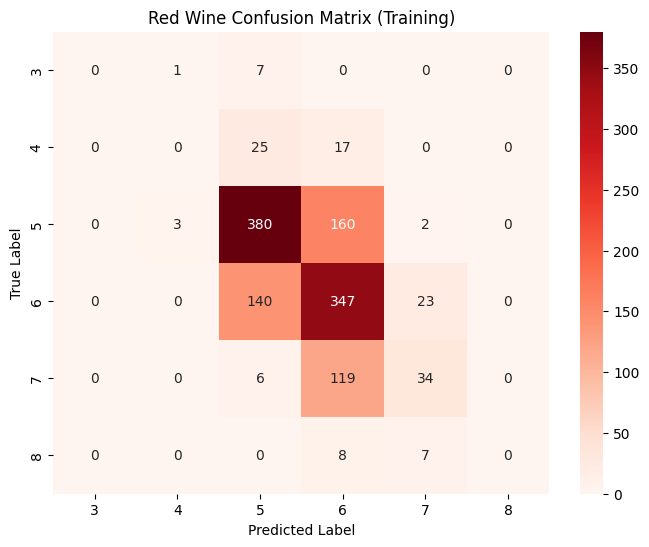

[0.         0.         0.68100358 0.53302611 0.51515152 0.        ]


In [11]:
red_labels = range(3,9)
red_train_pred = np.rint(red_lr_grid.predict(red_X_train))

red_train_class_precision = confusion_matrix_and_class_precision(red_Y_train,
                                                                 red_train_pred,
                                                                 red_labels,
                                                                 "Red Wine Confusion Matrix (Training)",
                                                                 "Reds")

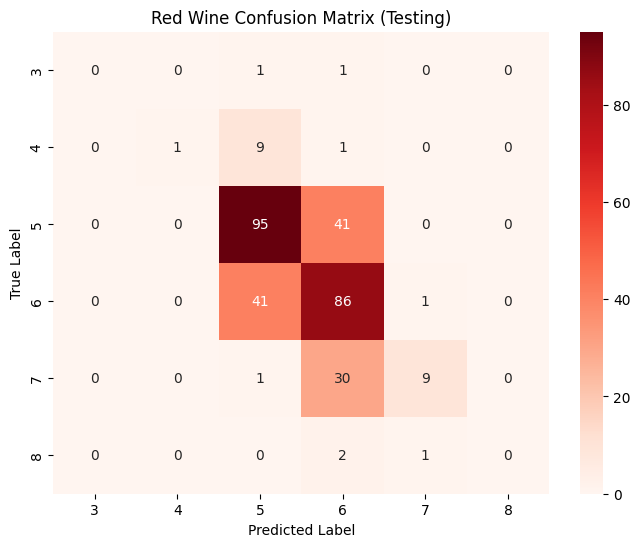

[0.         1.         0.6462585  0.53416149 0.81818182 0.        ]


In [12]:
red_test_pred = np.rint(red_lr_grid.predict(red_X_test))

red_test_class_precision = confusion_matrix_and_class_precision(red_Y_test,
                                                                red_test_pred,
                                                                red_labels,
                                                                "Red Wine Confusion Matrix (Testing)",
                                                                "Reds")

In [13]:
print("Accuracy:", accuracy_score(red_Y_test, red_test_pred))

Accuracy: 0.596875


Investigating coefficient values:

In [14]:
import pandas as pd

best_pipeline = red_lr_grid.best_estimator_

lr_model = best_pipeline.named_steps['model']
coefficients = lr_model.coef_


# Match with feature names
coef_df = pd.DataFrame({
    'feature': red_X_train.columns,
    'coefficient': coefficients
})

coef_df = coef_df.sort_values(by='coefficient', key=abs, ascending=False)
coef_df

,feature,coefficient
10,alcohol,0.316945
1,volatile acidity,-0.189923
9,sulphates,0.136724
6,total sulfur dioxide,-0.128430
8,pH,-0.091579
4,chlorides,-0.083329
5,free sulfur dioxide,0.065875
2,citric acid,-0.027374
7,density,-0.004113
3,residual sugar,0.002814


**Feature Selection**

In [15]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.svm import LinearSVR

red_lfs_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('sfs', SequentialFeatureSelector(LinearSVR(),
                                      n_features_to_select=1,
                                      direction='forward',
                                      scoring='neg_mean_squared_error')),
    ('model', LinearRegression()),
])

red_lfs_param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    'sfs__n_features_to_select': np.arange(3, 11)
}

red_lfs_grid = GridSearchCV(red_lfs_pipeline, red_lfs_param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
red_lfs_grid.fit(red_X_train, red_Y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('sfs',
                                        SequentialFeatureSelector(estimator=LinearSVR(),
                                                                  n_features_to_select=1,
                                                                  scoring='neg_mean_squared_error')),
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid={'scaler': [StandardScaler(), MinMaxScaler(),
                                    RobustScaler()],
                         'sfs__n_features_to_select': array([ 3,  4,  5,  6,  7,  8,  9, 10])},
             scoring='neg_mean_squared_error')

In [16]:
red_lfs_grid.best_params_

{'scaler': StandardScaler(), 'sfs__n_features_to_select': np.int64(7)}

Features selected:

In [17]:
red_X_train.columns[red_lfs_grid.best_estimator_['sfs'].get_support()]

Index(['volatile acidity', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'pH', 'sulphates', 'alcohol'],
      dtype='object')

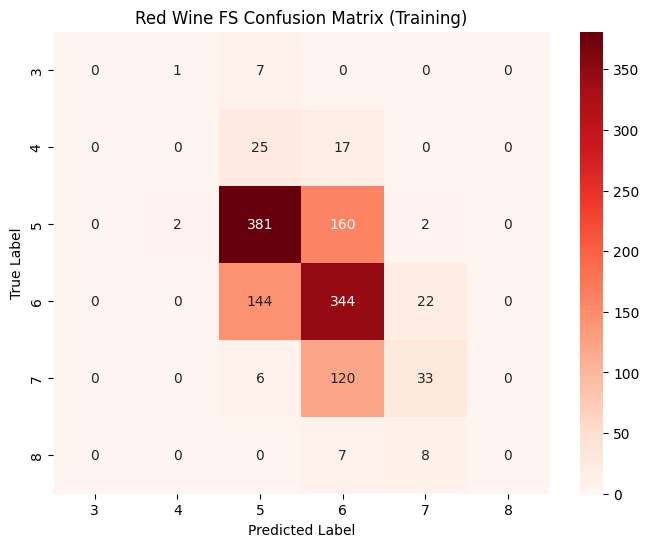

[0.         0.         0.67673179 0.5308642  0.50769231 0.        ]


In [18]:
red_sfs_train_pred = np.rint(red_lfs_grid.predict(red_X_train))

red_sfs_train_class_precision = confusion_matrix_and_class_precision(red_Y_train,
                                                                     red_sfs_train_pred,
                                                                     red_labels,
                                                                     "Red Wine FS Confusion Matrix (Training)",
                                                                     "Reds")

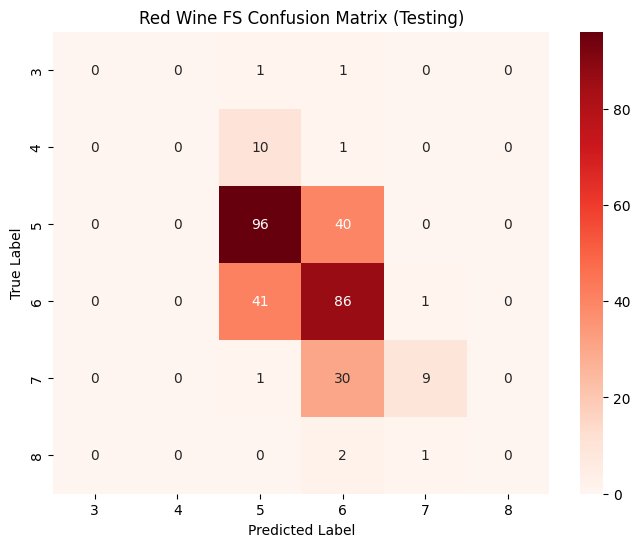

[0.         0.         0.6442953  0.5375     0.81818182 0.        ]


In [19]:
red_sfs_test_pred = np.rint(red_lfs_grid.predict(red_X_test))

red_sfs_test_class_precision = confusion_matrix_and_class_precision(red_Y_test,
                                                                    red_sfs_test_pred,
                                                                    red_labels,
                                                                    "Red Wine FS Confusion Matrix (Testing)",
                                                                    "Reds")

In [21]:
print("Accuracy:", accuracy_score(red_Y_test, red_sfs_test_pred))

Accuracy: 0.596875


Summary of class precisions:

In [22]:
red_class_precision_table = pd.DataFrame(zip(red_train_class_precision, red_test_class_precision,
                                             red_sfs_train_class_precision, red_sfs_test_class_precision),
                                         columns=['Training', 'Testing', 'FS Training', 'FS Testing'],
                                         index=red_labels)
red_class_precision_table.loc['Avg'] = red_class_precision_table.mean()

red_class_precision_table

,Training,Testing,FS Training,FS Testing
3,0.000000,0.000000,0.000000,0.000000
4,0.000000,1.000000,0.000000,0.000000
5,0.681004,0.646259,0.676732,0.644295
6,0.533026,0.534161,0.530864,0.537500
7,0.515152,0.818182,0.507692,0.818182
8,0.000000,0.000000,0.000000,0.000000
Avg,0.288197,0.499767,0.285881,0.333330


## White Wine Dataset

In [23]:
white_train, white_test = train_test_split(white_wine, test_size=0.2, random_state=42,
                                           stratify=white_wine['quality'])

In [24]:
white_X_train, white_Y_train = extract_X_and_Y(white_train, 'quality')
white_X_test, white_Y_test = extract_X_and_Y(white_test, 'quality')

In [25]:
white_lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

white_lr_param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()]
}

white_lr_grid = GridSearchCV(white_lr_pipeline, white_lr_param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
white_lr_grid.fit(white_X_train, white_Y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid={'scaler': [StandardScaler(), MinMaxScaler(),
                                    RobustScaler()]},
             scoring='neg_mean_squared_error')

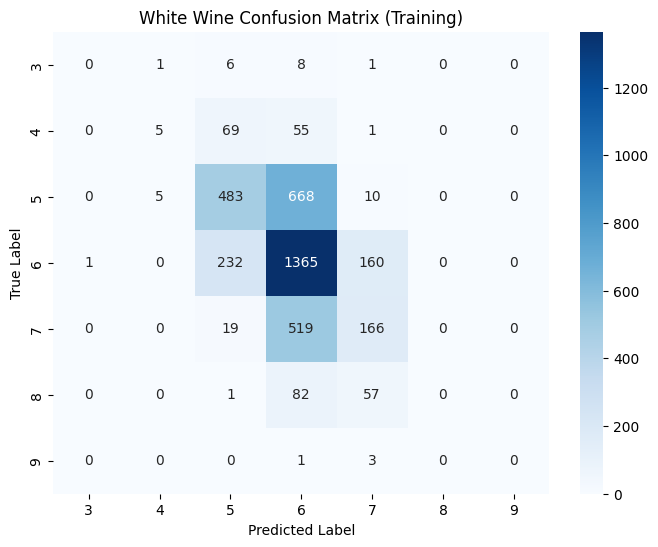

[0.         0.45454545 0.5962963  0.50593032 0.41708543 0.
 0.        ]


In [26]:
white_labels = range(3,10)
white_train_pred = np.rint(white_lr_grid.predict(white_X_train))

white_train_class_precision = confusion_matrix_and_class_precision(white_Y_train,
                                                                   white_train_pred,
                                                                   white_labels,
                                                                   "White Wine Confusion Matrix (Training)",
                                                                   "Blues")

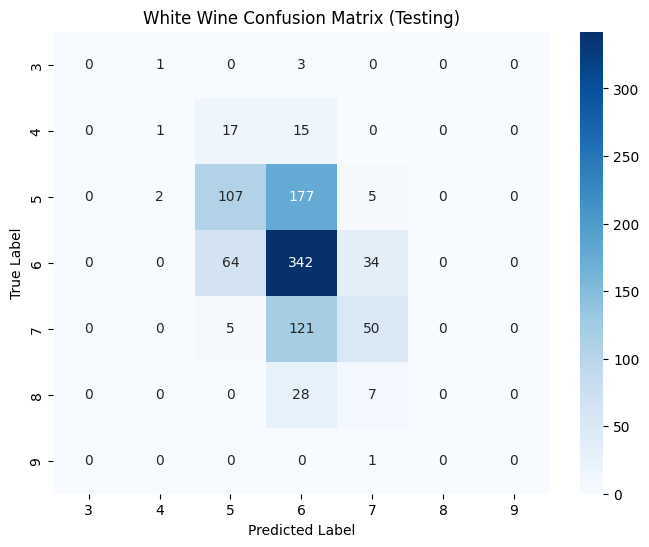

[0.         0.25       0.55440415 0.49854227 0.51546392 0.
 0.        ]


In [27]:
white_test_pred = np.rint(white_lr_grid.predict(white_X_test))

white_test_class_precision = confusion_matrix_and_class_precision(white_Y_test,
                                                                  white_test_pred,
                                                                  white_labels,
                                                                  "White Wine Confusion Matrix (Testing)",
                                                                  "Blues")

In [29]:
print("Accuracy:", accuracy_score(white_Y_test, white_test_pred))

Accuracy: 0.5102040816326531


**Feature Selection**

In [30]:
white_lfs_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('sfs', SequentialFeatureSelector(LinearSVR(),
                                      n_features_to_select=1,
                                      direction='forward',
                                      scoring='neg_mean_squared_error')),
    ('model', LinearRegression()),
])

white_lfs_param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    'sfs__n_features_to_select': np.arange(3, 11),
}

white_lfs_grid = GridSearchCV(white_lfs_pipeline, white_lfs_param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
white_lfs_grid.fit(white_X_train, white_Y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('sfs',
                                        SequentialFeatureSelector(estimator=LinearSVR(),
                                                                  n_features_to_select=1,
                                                                  scoring='neg_mean_squared_error')),
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid={'scaler': [StandardScaler(), MinMaxScaler(),
                                    RobustScaler()],
                         'sfs__n_features_to_select': array([ 3,  4,  5,  6,  7,  8,  9, 10])},
             scoring='neg_mean_squared_error')

In [31]:
white_lfs_grid.best_params_

{'scaler': RobustScaler(), 'sfs__n_features_to_select': np.int64(7)}

Features selected:

In [32]:
white_X_train.columns[white_lfs_grid.best_estimator_['sfs'].get_support()]

Index(['fixed acidity', 'volatile acidity', 'residual sugar',
       'free sulfur dioxide', 'density', 'sulphates', 'alcohol'],
      dtype='object')

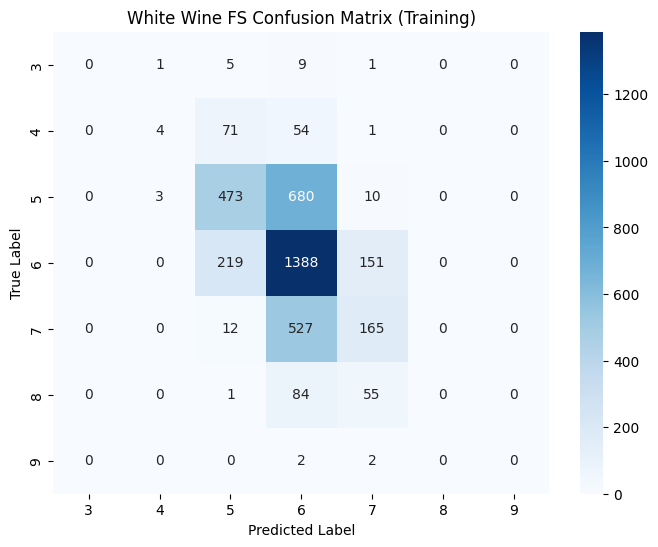

[0.         0.5        0.6056338  0.5058309  0.42857143 0.
 0.        ]


In [33]:
white_sfs_train_pred = np.rint(white_lfs_grid.predict(white_X_train))

white_sfs_train_class_precision = confusion_matrix_and_class_precision(white_Y_train,
                                                                       white_sfs_train_pred,
                                                                       white_labels,
                                                                       "White Wine FS Confusion Matrix (Training)",
                                                                       "Blues")

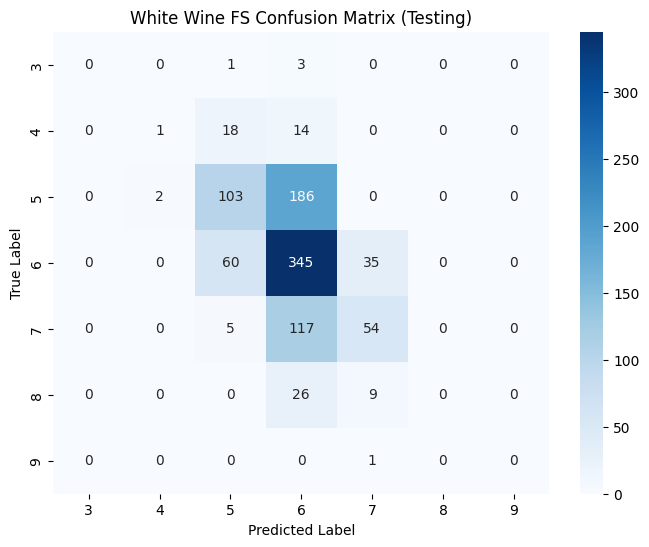

[0.         0.33333333 0.55080214 0.49927641 0.54545455 0.
 0.        ]


In [34]:
white_sfs_test_pred = np.rint(white_lfs_grid.predict(white_X_test))

white_sfs_test_class_precision = confusion_matrix_and_class_precision(white_Y_test,
                                                                      white_sfs_test_pred,
                                                                      white_labels,
                                                                      "White Wine FS Confusion Matrix (Testing)",
                                                                      "Blues")

In [35]:
print("Accuracy:", accuracy_score(white_Y_test, white_sfs_test_pred))

Accuracy: 0.513265306122449


In [36]:
white_class_precision_table = pd.DataFrame(zip(white_train_class_precision, white_test_class_precision,
                                               white_sfs_train_class_precision, white_sfs_test_class_precision),
                                           columns=['Training', 'Testing', 'FS Training', 'FS Testing'],
                                           index=white_labels)
white_class_precision_table.loc['Avg'] = white_class_precision_table.mean()

white_class_precision_table

,Training,Testing,FS Training,FS Testing
3,0.000000,0.000000,0.000000,0.000000
4,0.454545,0.250000,0.500000,0.333333
5,0.596296,0.554404,0.605634,0.550802
6,0.505930,0.498542,0.505831,0.499276
7,0.417085,0.515464,0.428571,0.545455
8,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000
Avg,0.281980,0.259773,0.291434,0.275552
